<a href="https://colab.research.google.com/github/softn12/Signboard_detection/blob/main/python_code/FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [4]:
if(torch.cuda.is_available()):
  device = torch.device("cuda")
  print(device, torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print(device)

cpu


(482, 720, 3)


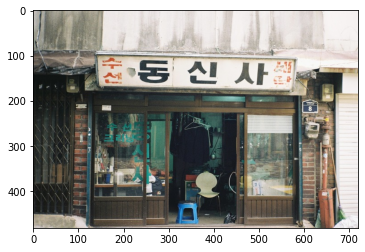

In [5]:
#input image could be of any size
img0 = cv2.imread('sign1.jpg')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()


In [44]:
# Object imformation : a set of bounding boxes [ymin, xmin, ymax, xmax] and their labels
bbox0 = np.array([90, 130, 190, 600])
labels = np.array([1]) #0 : background, 1: signboard

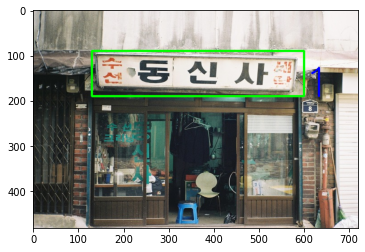

In [45]:
# display bounding box and labels
img0_clone = np.copy(img0)
for i in range(len(bbox0)):
  cv2.rectangle(img0_clone, (bbox0[1], bbox0[0]), (bbox0[3], bbox0[2]), color=(0, 255, 0), thickness=3)
  cv2.putText(img0_clone, str(int(labels[0])), (bbox0[3], bbox0[2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), thickness=3)
plt.imshow(img0_clone)
plt.show()